In [6]:
EPOCH = 1
ANNOTATION_JSON = "/Users/jagathkumarreddyk/Documents/GitHub/BLIP/annotations_trainval2014/annotations/captions_train2014.json"
IMAGE_ROOT = "/Users/jagathkumarreddyk/Documents/GitHub/BLIP/train2014/train2014"


import torch
import json
import os
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, AutoModelForCausalLM
from datasets import load_dataset
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

# =======================================================
# 3. Load Flickr8k dataset
# =======================================================
#dataset = load_dataset("jxie/flickr8k")
# flickr_data = dataset = load_dataset("jxie/flickr8k", split="train[:200]") #dataset['all']

# print(f"Columns: {flickr_data.column_names}")
# print(f"Number of examples: {len(flickr_data)}")

# =======================================================
# 4. Image transforms
# =======================================================
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3,[0.5]*3)
])

# =======================================================
# 5. Test image loading
# =======================================================
# sample_img = flickr_data[0]['image']
# plt.imshow(sample_img)
# plt.title(f"Sample Image\nCaption: {flickr_data[0]['caption_0']}")
# plt.axis('off')
# plt.show()


# =======================================================
# 6. Dataset class
# =======================================================
# class Flickr8kDataset(Dataset):
#     def __init__(self, dataset, tokenizer, max_length=30, transform=None):
#         self.dataset = dataset
#         self.tokenizer = tokenizer
#         self.max_length = max_length
#         self.transform = transform

#     def __len__(self):
#         return len(self.dataset)

#     def __getitem__(self, idx):
#         image = self.dataset[idx]['image']
#         if self.transform:
#             image = self.transform(image)
#         caption = self.dataset[idx]['caption_0']
#         tokenized = self.tokenizer(
#             caption,
#             truncation=True,
#             padding='max_length',
#             max_length=self.max_length,
#             return_tensors='pt'
#         )
#         input_ids = tokenized.input_ids.squeeze(0)
#         attention_mask = tokenized.attention_mask.squeeze(0)
#         return image, input_ids, attention_mask


# ============================================================================
# Dataset
# ============================================================================
class COCOCaptionDataset(Dataset):
    """COCO Captions Dataset"""
    def __init__(self, json_path, image_root, transform, tokenizer, max_length=50):
        with open(json_path, 'r') as f:
            self.data = json.load(f)
        
        self.image_root = image_root
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        # Flatten annotations
        self.samples = []
        for item in self.data['annotations']:
            img_id = item['image_id']
            # Find image filename
            img_info = next(img for img in self.data['images'] if img['id'] == img_id)
            self.samples.append({
                'image': os.path.join(image_root, img_info['file_name']),
                'caption': item['caption']
            })
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # Load and transform image
        image = Image.open(sample['image']).convert('RGB')
        image = self.transform(image)
        
        # Tokenize caption for encoder
        caption = sample['caption']
        text_encoding = self.tokenizer(
            caption,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        # Create decoder inputs (shifted right)
        decoder_input_ids = text_encoding['input_ids'].clone()
        labels = text_encoding['input_ids'].clone()
        labels[labels == self.tokenizer.pad_token_id] = -100
        
        return {
            'image': image,
            'text_input_ids': text_encoding['input_ids'].squeeze(0),
            'text_attention_mask': text_encoding['attention_mask'].squeeze(0),
            'decoder_input_ids': decoder_input_ids.squeeze(0),
            'decoder_attention_mask': text_encoding['attention_mask'].squeeze(0),
            'labels': labels.squeeze(0)
        }




# =======================================================
# 7. Load tokenizer + model
# =======================================================
tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token

# Add special <img> token
if '<img>' not in tokenizer.get_vocab():
    tokenizer.add_special_tokens({'additional_special_tokens':['<img>']})
img_token_id = tokenizer.convert_tokens_to_ids('<img>')

# Load DistilGPT2 via AutoModelForCausalLM
gpt2 = AutoModelForCausalLM.from_pretrained("distilgpt2")
gpt2.resize_token_embeddings(len(tokenizer))
gpt2.eval()

# =======================================================
# 8. Q-Former
# =======================================================
from transformers import ViTModel
vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
vit.eval()

class QFormer(nn.Module):
    def __init__(self, image_emb_dim, prompt_len=16, hidden_dim=768):
        super().__init__()
        self.query_tokens = nn.Parameter(torch.randn(prompt_len, image_emb_dim))
        self.cross_attn = nn.MultiheadAttention(embed_dim=image_emb_dim, num_heads=8)
        self.mlp = nn.Linear(image_emb_dim, hidden_dim)

    def forward(self, image_embeds):
        batch_size = image_embeds.size(0)
        query = self.query_tokens.unsqueeze(1).repeat(1,batch_size,1)
        attn_out,_ = self.cross_attn(query, image_embeds.transpose(0,1), image_embeds.transpose(0,1))
        prompt = self.mlp(attn_out).transpose(0,1)
        return prompt


q_former = QFormer(image_emb_dim=vit.config.hidden_size, prompt_len=16, hidden_dim=gpt2.config.n_embd)

# =======================================================
# 9. DataLoader
# =======================================================
train_dataset = COCOCaptionDataset(json_path=ANNOTATION_JSON, image_root=IMAGE_ROOT, transform=transform,tokenizer=tokenizer, max_length=50)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# =======================================================
# 10. Device setup
# =======================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit.to(device)
gpt2.to(device)
q_former.to(device)



# =======================================================
# 11. Partial GPT-2 fine-tuning
# =======================================================
N_LAST_LAYERS = 4  # fine-tune last 4 layers

# Freeze all GPT-2 parameters
for param in gpt2.transformer.parameters():
    param.requires_grad = False

# Unfreeze last N layers
for block in gpt2.transformer.h[-N_LAST_LAYERS:]:
    for param in block.parameters():
        param.requires_grad = True

# Unfreeze embedding for <img> token
for param in gpt2.transformer.wte.parameters():
    param.requires_grad = True

# Unfreeze LM head
for param in gpt2.lm_head.parameters():
    param.requires_grad = True

# Optimizer for trainable params
trainable_params = filter(lambda p: p.requires_grad, gpt2.parameters())
optimizer = torch.optim.AdamW(list(trainable_params) + list(q_former.parameters()), lr=5e-5)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)


In [8]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [9]:

# =======================================================
# 12. Training loop (demo)
# =======================================================
for epoch in range(EPOCH):  # increase to 5–10 epochs for better results
    q_former.train()
    gpt2.train()
    total_loss = 0

        # {    'image': image,
        #     'text_input_ids': text_encoding['input_ids'].squeeze(0),
        #     'text_attention_mask': text_encoding['attention_mask'].squeeze(0),
        #     'decoder_input_ids': decoder_input_ids.squeeze(0),
        #     'decoder_attention_mask': text_encoding['attention_mask'].squeeze(0),
        #     'labels': labels.squeeze(0)
        # }


    for dict_of_img_txt in tqdm(train_loader):
        images = dict_of_img_txt["image"]
        input_ids = dict_of_img_txt["text_input_ids"]
        
        images, input_ids = images.to(device), input_ids.to(device)

        with torch.no_grad():
            image_embeds = vit(images).last_hidden_state

        prompts = q_former(image_embeds)

        # Prepend <img> token
        img_token_emb = gpt2.transformer.wte(torch.tensor([img_token_id]*images.size(0), device=device).unsqueeze(1))
        gpt2_inputs = gpt2.transformer.wte(input_ids)
        gpt2_inputs = torch.cat([img_token_emb, prompts, gpt2_inputs], dim=1)

        outputs = gpt2(inputs_embeds=gpt2_inputs)
        logits = outputs.logits

        prompt_len = 1 + prompts.size(1)
        loss = criterion(logits[:, prompt_len:-1,:].reshape(-1, logits.size(-1)), input_ids[:,1:].reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch} Loss: {total_loss/len(train_loader)}")



  0%|          | 7/25883 [00:24<25:13:08,  3.51s/it]


KeyboardInterrupt: 

In [55]:
# =======================================================
# 13. Inference with top-k/top-p sampling
# =======================================================
def generate_caption(pil_image, vit, q_former, gpt2, tokenizer, device, max_length=30, top_k=50, top_p=0.95):
    vit.eval()
    q_former.eval()
    gpt2.eval()
    image = transform(pil_image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_embeds = vit(image).last_hidden_state
        prompts = q_former(image_embeds)
        input_ids = torch.tensor([[tokenizer.bos_token_id]], device=device)
        img_token_emb = gpt2.transformer.wte(torch.tensor([[img_token_id]], device=device))
        generated = []

        for _ in range(max_length):
            gpt2_inputs = gpt2.transformer.wte(input_ids)
            gpt2_inputs = torch.cat([img_token_emb, prompts, gpt2_inputs], dim=1)

            outputs = gpt2(inputs_embeds=gpt2_inputs)
            logits = outputs.logits[0, -1, :]

            # Top-k + top-p sampling
            filtered_logits = torch.nn.functional.softmax(logits, dim=-1)
            next_token = torch.multinomial(filtered_logits, num_samples=1)

            if next_token.item() == tokenizer.eos_token_id:
                break
            generated.append(next_token.item())
            input_ids = torch.cat([input_ids, next_token.unsqueeze(0)], dim=1)

        caption = tokenizer.decode(generated, skip_special_tokens=True)
        return caption

# =======================================================
# 14. Test generated captions
# =======================================================
        # {    'image': image,
        #     'text_input_ids': text_encoding['input_ids'].squeeze(0),
        #     'text_attention_mask': text_encoding['attention_mask'].squeeze(0),
        #     'decoder_input_ids': decoder_input_ids.squeeze(0),
        #     'decoder_attention_mask': text_encoding['attention_mask'].squeeze(0),
        #     'labels': labels.squeeze(0)
        # }

import numpy as np

def generate_output(num_samples):
    for i in range(num_samples):
        img = (((train_dataset[0]['image'] + 1)/2).mul(255)).byte()
        img = img.permute(1,2,0)
        print(img.shape)
        img = Image.fromarray(img.numpy())
        gt_caption = tokenizer.decode(train_dataset[i]['text_input_ids'])
        gen_caption = generate_caption(img, vit, q_former, gpt2, tokenizer, device)

        print("GT caption: " + gt_caption)
        print("Generated caption: " + gen_caption)





torch.Size([224, 224, 3])


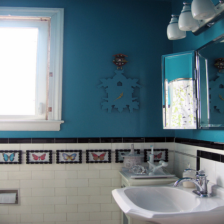

In [56]:
img = (((train_dataset[0]['image'] + 1)/2).mul(255)).byte()
img = img.permute(1,2,0)
print(img.shape)
Image.fromarray(img.numpy())

In [57]:
generate_output(3)

torch.Size([224, 224, 3])
GT caption: A very clean and well decorated empty bathroom<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
Generated caption: Möller-born family business entrepreneur Kinky Night is the largest Freestyle rink in the world. This is the state of civilization. This und
torch.Size([224, 224, 3])
GT caption: A panoramic view of a kitchen and all of its appliances.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext

In [58]:
checkpoint = {
    "gpt2_state" : gpt2.state_dict(),
    "qformer" : q_former.state_dict(),
    "optimizer":optimizer.state_dict(),
    "epoch":epoch
}
torch.save(checkpoint,f"checkpoint_{epoch}.pth")

In [59]:
checkpoint_obj = torch.load("checkpoint_0.pth")
gpt2_loaded = gpt2.load_state_dict(checkpoint_obj["gpt2_state"])
q_former_loaded = q_former.load_state_dict(checkpoint_obj["qformer"])

In [60]:
generate_output(5)

torch.Size([224, 224, 3])
GT caption: A very clean and well decorated empty bathroom<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
Generated caption: Prosecutors say a man was shot after attending a gym in baseball practice.




SAN FRANCISCO -- An apparent threat to law
torch.Size([224, 224, 3])
GT caption: A panoramic view of a kitchen and all of its appliances.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|en